# Transfer learning 11 classes

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import datetime, os
import matplotlib.pyplot as plt

In [3]:
batch_size = 32
img_height = 150
img_width = 150

def aug_train_validation_data(batch_size = 32, img_height = 150, img_width = 150):
    """
    Inputs and processes image files with yoga poses. 
    Splits the data to train and validation subsets.
    Returns train_generator and test_generator.
    """
    train_datagen = ImageDataGenerator(
                                        rescale=1./255,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True, 
                                        rotation_range=20,
                                        zca_whitening=False, 
                                        zca_epsilon=1e-06,  
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        validation_split=0.2
                                        )

    train_generator = train_datagen.flow_from_directory(
            '/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/my_train_set',
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='sparse',
            color_mode='rgb',
            subset='training')

    validation_generator = train_datagen.flow_from_directory(
            '/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/my_train_set',
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='sparse',
            color_mode='rgb',
            subset='validation')
    return train_generator, validation_generator

def test_data(shuffle=True, 
              data_folder='/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/my_test_set',
              target_size=(img_height, img_width)):
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(
        data_folder,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        color_mode='rgb',
        shuffle=shuffle)
    return test_generator

def steps(n_train_total=631, n_val_total=152):
    steps_per_epoch = n_train_total//batch_size
    validation_steps = n_val_total //batch_size

    print(steps_per_epoch)
    print(validation_steps)

    return steps_per_epoch, validation_steps

In [4]:
train_generator, validation_generator = aug_train_validation_data()
test_generator = test_data()

steps_per_epoch, validation_steps = steps()

Found 895 images belonging to 11 classes.
Found 219 images belonging to 11 classes.
Found 116 images belonging to 11 classes.
19
4


## model


In [5]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False
base_model.summary()

inputs = keras.Input(shape=(img_height, img_width, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)

x = keras.layers.Dense(128, activation = "relu")(x)
outputs = keras.layers.Dense(11, activation = "softmax")(x)
model = keras.Model(inputs, outputs)


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
images = next(validation_generator)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
plt.imshow(images[0][0])

In [ ]:
logdir = os.path.join("/content/drive/My Drive/GALVANIZE/logs/tr_learn", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

result = model.fit(
                  train_generator,
                  steps_per_epoch=19,
                  epochs=20,
                  validation_data=validation_generator,
                  validation_steps=4,
                  callbacks=[tensorboard_callback])

# Logfile name:
print(f'Log directory path: {logdir}')
# Save model
modeldir = os.path.join("/content/drive/My Drive/GALVANIZE/models/tr_learn", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model.save(modeldir) 
# # Load model
# new_model = tf.keras.models.load_model('/content/drive/My Drive/GALVANIZE/models/first_model')
# new_model.summary()

Epoch 1/20
 1/19 [>.............................] - ETA: 0s - loss: 2.4833 - accuracy: 0.1250WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 9/19 [=============>................] - ETA: 2:12 - loss: 2.4013 - accuracy: 0.1007

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


19/19 [==============================] - 322s 17s/step - loss: 2.3506 - accuracy: 0.1565 - val_loss: 2.2013 - val_accuracy: 0.3438
Epoch 2/20
19/19 [==============================] - 100s 5s/step - loss: 2.1096 - accuracy: 0.3163 - val_loss: 2.0311 - val_accuracy: 0.3281
Epoch 3/20
19/19 [==============================] - 40s 2s/step - loss: 1.8996 - accuracy: 0.4375 - val_loss: 1.8876 - val_accuracy: 0.4453
Epoch 4/20
19/19 [==============================] - 38s 2s/step - loss: 1.7337 - accuracy: 0.5140 - val_loss: 1.7168 - val_accuracy: 0.5547
Epoch 5/20
19/19 [==============================] - 25s 1s/step - loss: 1.5807 - accuracy: 0.5806 - val_loss: 1.6283 - val_accuracy: 0.5156
Epoch 6/20
19/19 [==============================] - 24s 1s/step - loss: 1.4513 - accuracy: 0.6227 - val_loss: 1.4702 - val_accuracy: 0.6250
Epoch 7/20
19/19 [==============================] - 23s 1s/step - loss: 1.3152 - accuracy: 0.6562 - val_loss: 1.5109 - val_accuracy: 0.5547
Epoch 8/20
19/19 [==========

In [ ]:
modeldir = os.path.join("/content/drive/My Drive/GALVANIZE/models/tr_learn", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model.save(modeldir) 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/GALVANIZE/models/tr_learn/20200827-172924/assets


# Results analysis

## imports

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import datetime, os
import matplotlib.pyplot as plt

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
from sklearn import metrics

In [9]:
batch_size = 32
img_height = 150
img_width = 150

## data load

### functions

In [15]:
batch_size = 32
img_height = 150
img_width = 150

def aug_train_validation_data(batch_size = 32, img_height = 150, img_width = 150):
    """
    Inputs and processes image files with yoga poses. 
    Splits the data to train and validation subsets.
    Returns train_generator and test_generator.
    """
    train_datagen = ImageDataGenerator(
                                        rescale=1./255,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True, 
                                        rotation_range=20,
                                        zca_whitening=False, 
                                        zca_epsilon=1e-06,  
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        validation_split=0.2
                                        )

    train_generator = train_datagen.flow_from_directory(
            '/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/my_train_set',
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='sparse',
            color_mode='rgb',
            subset='training')

    validation_generator = train_datagen.flow_from_directory(
            '/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/my_train_set',
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='sparse',
            color_mode='rgb',
            subset='validation')
    return train_generator, validation_generator

def test_data(shuffle=True, 
              data_folder='/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/my_test_set',
              target_size=(img_height, img_width)):
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(
        data_folder,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        color_mode='rgb',
        shuffle=shuffle)
    return test_generator

def gray_test_data(shuffle=True, 
              data_folder='/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/my_test_set',
              target_size=(img_height, img_width)):
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(
        data_folder,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse',
        color_mode='grayscale')
    return test_generator


def steps(n_train_total=631, n_val_total=152):
    steps_per_epoch = n_train_total//batch_size
    validation_steps = n_val_total //batch_size

    print(steps_per_epoch)
    print(validation_steps)

    return steps_per_epoch, validation_steps

# SHOW CONFUSION MATRIX

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      cm = cm * 100
      print("\nNormalized confusion matrix")
  else:
      print('\nConfusion matrix, without normalization')
  print(cm)
  print ()

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)

  fmt = '.0f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

## Tensorboard

In [27]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard serve --logdir "/content/drive/My Drive/GALVANIZE/logs/aug4L_learn20200828-001448"

In [ ]:
%tensorboard serve --logdir "/content/drive/My Drive/GALVANIZE/logs/tr_learn/20200828-001102"

## model load

In [32]:
# Load model
aug_4g_model = tf.keras.models.load_model('/content/drive/My Drive/GALVANIZE/models/aug4L_learn/20200828-003551')
# new_model.summary()
tr_model_4cl = tf.keras.models.load_model('/content/drive/My Drive/GALVANIZE/models/tr_learn/20200828-022843')
tr_model_4cl.summary()
tr_model_11cl = tf.keras.models.load_model('/content/drive/My Drive/GALVANIZE/models/tr_learn/20200828-023232')
tr_model_11cl.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 200, 200, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 6, 6, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_9 (Dense)              (None, 11)                1419      
Total params: 20,091,467
Trainable params: 20,091,467
Non-trainable params: 0
_________________________________________________________________
Model: "functional_11"
_________________________________________________________________
Layer (type)       

## test data

In [33]:
gray_test_generator_g = gray_test_data(shuffle=False, data_folder='/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/galvanize_doing_yoga')
gray_test_generator = gray_test_data(shuffle=False, data_folder='/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/my_test_set')

test_generator_g = test_data(shuffle=False, data_folder='/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/galvanize_doing_yoga')
test_generator = test_data(shuffle=False, data_folder='/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/my_test_set')


Found 43 images belonging to 11 classes.
Found 116 images belonging to 11 classes.
Found 43 images belonging to 11 classes.
Found 116 images belonging to 11 classes.


In [17]:
gray_test_labels = gray_test_generator.classes
gray_test_labels_g = gray_test_generator_g.classes

test_labels = test_generator.classes
test_labels_g = test_generator_g.classes

In [22]:
class_names = list(gray_test_generator.class_indices.keys())

In [38]:
class_names
test_labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10],
      dtype=int32)

## Predictions

### model from scratch

In [19]:
predictions_4L = aug_4g_model.predict(gray_test_generator)
predictions_g_4L = aug_4g_model.predict(gray_test_generator_g)

In [ ]:
test_labels
predictions
class_names

### model tr learn

In [35]:
predictions_tr = model_11cl.predict(test_generator)
predictions_g_tr = model_11cl.predict(test_generator_g)

In [39]:
y_pred_tr = np.argmax(predictions_tr, axis=1)
print(y_pred_tr)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2
 2 2 0 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 0 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 0 2
 2 2 2 2 1]


In [ ]:
y_pred_g_tr = np.argmax(predictions_g_tr, axis=1)
print(y_pred_tr)

### Confusion matrix tr

#### custom

In [ ]:
# Compute confusion matrix
y_pred = np.argmax(predictions_tr, axis=1)
cnf_matrix = confusion_matrix(test_labels, y_pred)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig("/content/drive/My Drive/GALVANIZE/figs/non_normalized_cf_tr_learn.jpg")

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig("/content/drive/My Drive/GALVANIZE/figs/gray_custom_test.png")

#### galvanize

In [ ]:
# Compute confusion matrix
y_pred = np.argmax(predictions_g_tr, axis=1)
cnf_matrix = confusion_matrix(test_labels_g, y_pred)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig("/content/drive/My Drive/GALVANIZE/figs/non_normalized_cf_tr_learn.jpg")

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig("/content/drive/My Drive/GALVANIZE/figs/gray_custom_test.png")

### Confusion matrix 4L

#### custom test


Confusion matrix, without normalization
[[3 0 0 2 2 1 3 0 1 0 1]
 [0 2 1 1 0 0 2 0 2 0 2]
 [2 4 1 1 1 0 2 2 3 0 1]
 [3 5 3 8 3 2 1 1 1 1 2]
 [0 2 2 1 0 1 1 0 0 0 0]
 [2 0 2 1 1 0 0 1 1 0 2]
 [1 1 1 1 1 0 0 1 0 0 1]
 [0 3 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 1 0 1 1 1]
 [0 1 0 1 0 0 0 1 1 0 1]
 [1 3 0 1 0 0 0 0 0 1 1]]



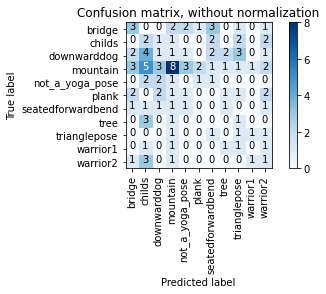


Normalized confusion matrix
[[23.08  0.    0.   15.38 15.38  7.69 23.08  0.    7.69  0.    7.69]
 [ 0.   20.   10.   10.    0.    0.   20.    0.   20.    0.   20.  ]
 [11.76 23.53  5.88  5.88  5.88  0.   11.76 11.76 17.65  0.    5.88]
 [10.   16.67 10.   26.67 10.    6.67  3.33  3.33  3.33  3.33  6.67]
 [ 0.   28.57 28.57 14.29  0.   14.29 14.29  0.    0.    0.    0.  ]
 [20.    0.   20.   10.   10.    0.    0.   10.   10.    0.   20.  ]
 [14.29 14.29 14.29 14.29 14.29  0.    0.   14.29  0.    0.   14.29]
 [ 0.   60.    0.   20.    0.    0.    0.    0.   20.    0.    0.  ]
 [ 0.    0.    0.   20.    0.    0.   20.    0.   20.   20.   20.  ]
 [ 0.   20.    0.   20.    0.    0.    0.   20.   20.    0.   20.  ]
 [14.29 42.86  0.   14.29  0.    0.    0.    0.    0.   14.29 14.29]]



<Figure size 432x288 with 0 Axes>

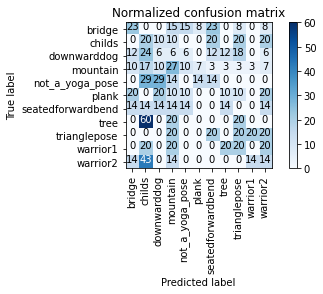

<Figure size 432x288 with 0 Axes>

In [23]:
# Compute confusion matrix
y_pred = np.argmax(predictions_4L, axis=1)
cnf_matrix = confusion_matrix(gray_test_labels, y_pred)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig("/content/drive/My Drive/GALVANIZE/figs/non_normalized_cf_tr_learn.jpg")

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig("/content/drive/My Drive/GALVANIZE/figs/gray_custom_test.png")

### accuracy and other metrics

#### custom

In [25]:
y_pred_c = np.argmax(predictions_tr, axis=1)

In [26]:
y_true_c = test_labels
print(f'Accuracy: {metrics.accuracy_score(y_true_c,y_pred_c)}')

0.13793103448275862

In [ ]:
test_generator = test_data(shuffle=False, 
                           data_folder="/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/me_doing_yoga")

predictions = model.predict(test_generator)
test_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

Found 11 images belonging to 11 classes.


In [ ]:
print(test_labels)
print(class_names)

[ 0  1  2  3  4  5  6  7  8  9 10]
['bridge', 'childs', 'downwarddog', 'mountain', 'not_a_yoga_pose', 'plank', 'seatedforwardbend', 'tree', 'trianglepose', 'warrior1', 'warrior2']


In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_pred

array([ 2,  4,  2,  3,  1,  5, 10,  3,  8,  3, 10])

In [ ]:
cnf_matrix = confusion_matrix(test_labels, y_pred)

In [ ]:
images=next(test_generator)

probabilities = []
for n, image in enumerate(images[0]):
    dct = {}
    for i, cls_name in enumerate(class_names):
        dct[cls_name] = predictions[n][i]
    probabilities.append(dct)


plt.style.use('ggplot')
fig, ax = plt.subplots(2, 5,figsize=(15,8))

for j in range(5):
  i=0
  ax[i,j].imshow(images[0][j+1])
  ax[i,j].axis("off")
  ax[i,j].set_title(f'True: {class_names[j+1]} \n Predicted: {class_names[y_pred[j+1]]}')
  # ax[i+1,j].set_yticks("off")
  # ax[i+1,j].set_yticklabels("off")


  # y_pos = np.arange(len(predictions[j]))
  # ax[i+1,j].barh(y_pos, predictions[j])
  # ax[i+1,j].set_yticks(y_pos)
  # ax[i+1,j].set_yticklabels(class_names)

  i=1
  ax[i,j].imshow(images[0][6+j])
  ax[i,j].axis("off")
  ax[i,j].set_title(f'True: {class_names[6+j]} \n Predicted: {class_names[y_pred[6+j]]}')

  # y_pos = np.arange(len(predictions[j]))
  # ax[i+1,j].barh(y_pos, predictions[j])
  # ax[i+1,j].set_yticks(y_pos)
  # ax[i+1,j].set_yticklabels(class_names)


# # Example data
# people = ('Tom', 'Dick', 'Harry', 'Slim', 'Jim')
# y_pos = np.arange(len(people))
# performance = 3 + 10 * np.random.rand(len(people))
# error = np.random.rand(len(people))

# ax.barh(y_pos, performance, xerr=error, align='center')
# ax.set_yticks(y_pos)
# ax.set_yticklabels(people)
# ax.invert_yaxis()  # labels read top-to-bottom
# ax.set_xlabel('Performance')
# ax.set_title('How fast do you want to go today?')

# plt.show()
fig.savefig("/content/drive/My Drive/GALVANIZE/figs/me_tr_model_predictions.jpg")

In [ ]:
probabilities[i+j].keys()

dict_keys(['childs', 'downwarddog', 'mountain', 'not_a_yoga_pose', 'plank', 'seatedforwardbend', 'tree', 'triangle', 'warrior1', 'warrior2'])

In [ ]:
plt.imshow(images[0][0])

In [ ]:
images[0][0]

array([[[0.51, 0.42, 0.51],
        [0.52, 0.42, 0.5 ],
        [0.53, 0.43, 0.51],
        ...,
        [0.79, 0.68, 0.53],
        [0.8 , 0.67, 0.51],
        [0.8 , 0.67, 0.51]],

       [[0.53, 0.44, 0.53],
        [0.51, 0.42, 0.5 ],
        [0.53, 0.43, 0.51],
        ...,
        [0.8 , 0.68, 0.53],
        [0.77, 0.66, 0.49],
        [0.78, 0.66, 0.49]],

       [[0.49, 0.41, 0.51],
        [0.5 , 0.42, 0.49],
        [0.53, 0.43, 0.51],
        ...,
        [0.76, 0.63, 0.48],
        [0.75, 0.61, 0.45],
        [0.76, 0.61, 0.44]],

       ...,

       [[0.8 , 0.84, 0.87],
        [0.76, 0.79, 0.82],
        [0.76, 0.79, 0.81],
        ...,
        [0.72, 0.57, 0.39],
        [0.71, 0.55, 0.38],
        [0.72, 0.56, 0.38]],

       [[0.78, 0.82, 0.85],
        [0.77, 0.81, 0.84],
        [0.79, 0.82, 0.84],
        ...,
        [0.71, 0.55, 0.37],
        [0.72, 0.56, 0.39],
        [0.73, 0.56, 0.39]],

       [[0.78, 0.82, 0.85],
        [0.78, 0.82, 0.84],
        [0.78, 0

In [ ]:
class_names_converter = {'downwarddog':'Adho Mukha Shvanasana',
'childs':'Balasana',
'triangle':'Utthita Trikonasana',
'bridge': "Setu Bandha Sarvangasana(light) or Urdhva Dhanurasana(full)",
'warrior 1': 'Virabhadrasana I',
'warrior 2': 'Virabhadrasana II',
'tree': 'Vrikshasana',
'mountain':'Tadasana',
'plank': 'Phalakasana',
'seatedforwardbend':'Paschimottanasana'}

In [ ]:
test_generator = test_data(shuffle=False, 
                           data_folder="/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/someone_doing_yoga")

predictions = model.predict(test_generator)
test_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

Found 10 images belonging to 11 classes.


In [ ]:
print(test_labels)
print(class_names)

[ 0  1  2  3  4  5  6  7  9 10]
['bridge', 'childs', 'downwarddog', 'mountain', 'not_a_yoga_pose', 'plank', 'seatedforwardbend', 'tree', 'trianglepose', 'warrior1', 'warrior2']


In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_pred

array([ 0,  1,  2,  3,  4,  5,  2,  7,  9, 10])

In [ ]:
images=next(test_generator)

probabilities = []
for n, image in enumerate(images[0]):
    dct = {}
    for i, cls_name in enumerate(class_names):
        dct[cls_name] = predictions[n][i]
    probabilities.append(dct)


plt.style.use('ggplot')
fig, ax = plt.subplots(2, 5,figsize=(15,8))

for j in range(5):
  i=0
  ax[i,j].imshow(images[0][j])
  ax[i,j].axis("off")
  ax[i,j].set_title(f'True: {class_names[j]} \n Predicted: {class_names[y_pred[j]]}')
  # ax[i+1,j].set_yticks("off")
  # ax[i+1,j].set_yticklabels("off")


  # y_pos = np.arange(len(predictions[j]))
  # ax[i+1,j].barh(y_pos, predictions[j])
  # ax[i+1,j].set_yticks(y_pos)
  # ax[i+1,j].set_yticklabels(class_names)

  i=1
  ax[i,j].imshow(images[0][5+j])
  ax[i,j].axis("off")
  ax[i,j].set_title(f'True: {class_names[5+j]} \n Predicted: {class_names[y_pred[5+j]]}')

  # y_pos = np.arange(len(predictions[j]))
  # ax[i+1,j].barh(y_pos, predictions[j])
  # ax[i+1,j].set_yticks(y_pos)
  # ax[i+1,j].set_yticklabels(class_names)


# # Example data
# people = ('Tom', 'Dick', 'Harry', 'Slim', 'Jim')
# y_pos = np.arange(len(people))
# performance = 3 + 10 * np.random.rand(len(people))
# error = np.random.rand(len(people))

# ax.barh(y_pos, performance, xerr=error, align='center')
# ax.set_yticks(y_pos)
# ax.set_yticklabels(people)
# ax.invert_yaxis()  # labels read top-to-bottom
# ax.set_xlabel('Performance')
# ax.set_title('How fast do you want to go today?')

# plt.show()
fig.savefig("/content/drive/My Drive/GALVANIZE/figs/me_tr_model_predictions.jpg")

In [ ]:
probabilities[i+j].keys()

dict_keys(['childs', 'downwarddog', 'mountain', 'not_a_yoga_pose', 'plank', 'seatedforwardbend', 'tree', 'triangle', 'warrior1', 'warrior2'])

# Transfer learning sub set


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import datetime, os
import matplotlib.pyplot as plt

In [ ]:
batch_size = 32
img_height = 200
img_width = 200

In [ ]:
def aug_train_validation_data(batch_size = 32, img_height = 150, img_width = 150):
    """
    Inputs and processes image files with yoga poses. 
    Splits the data to train and validation subsets.
    Returns train_generator and test_generator.
    """
    train_datagen = ImageDataGenerator(
                                        rescale=1./255,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True, 
                                        rotation_range=20,
                                        zca_whitening=False, 
                                        zca_epsilon=1e-06,  
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        validation_split=0.2
                                        )

    train_generator = train_datagen.flow_from_directory(
            '/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/sub_train',
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='sparse',
            color_mode='rgb',
            subset='training')

    validation_generator = train_datagen.flow_from_directory(
            '/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/sub_train',
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='sparse',
            color_mode='rgb',
            subset='validation')
    return train_generator, validation_generator

def test_data(shuffle=True, 
              data_folder='/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/sub_test',
              target_size=(img_height, img_width)):
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(
        data_folder,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        color_mode='rgb',
        shuffle=shuffle)
    return test_generator

def steps(n_train_total=327, n_val_total=79):
    steps_per_epoch = n_train_total//batch_size
    validation_steps = n_val_total //batch_size

    print(steps_per_epoch)
    print(validation_steps)

    return steps_per_epoch, validation_steps

In [ ]:
batch_size = 32
img_height = 200
img_width = 200

train_generator, validation_generator = aug_train_validation_data()
test_generator = test_data()

steps_per_epoch, validation_steps = steps()

Found 327 images belonging to 4 classes.
Found 79 images belonging to 4 classes.
Found 34 images belonging to 4 classes.
10
2


In [ ]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False
base_model.summary()

inputs = keras.Input(shape=(img_height, img_width, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)

x = keras.layers.Dense(128, activation = "relu")(x)
outputs = keras.layers.Dense(4, activation = "softmax")(x)
model_2 = keras.Model(inputs, outputs)


model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_2.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
______________________________________________________________

In [ ]:
images = next(validation_generator)

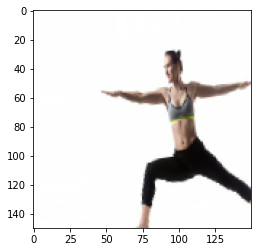

In [ ]:
plt.imshow(images[0][0])

In [ ]:
logdir = os.path.join("/content/drive/My Drive/GALVANIZE/logs/tr_learn", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

result = model_2.fit(
                  train_generator,
                  steps_per_epoch=10,
                  epochs=40,
                  validation_data=validation_generator,
                  validation_steps=2,
                  callbacks=[tensorboard_callback])

# Logfile name:
print(f'Log directory path: {logdir}')
# Save model
modeldir = os.path.join("/content/drive/My Drive/GALVANIZE/models/tr_learn", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model_2.save(modeldir) 
# # Load model
# new_model = tf.keras.models.load_model('/content/drive/My Drive/GALVANIZE/models/first_model')
# new_model.summary()

Epoch 1/40
 1/10 [==>...........................] - ETA: 0s - loss: 1.5777 - accuracy: 0.3125WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 2/10 [=====>........................] - ETA: 1:06 - loss: 1.4753 - accuracy: 0.2969

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10/10 [==============================] - 148s 15s/step - loss: 1.3673 - accuracy: 0.3559 - val_loss: 1.3012 - val_accuracy: 0.2969
Epoch 2/40
10/10 [==============================] - 11s 1s/step - loss: 1.1655 - accuracy: 0.5729 - val_loss: 1.1641 - val_accuracy: 0.4844
Epoch 3/40
10/10 [==============================] - 11s 1s/step - loss: 1.0549 - accuracy: 0.5593 - val_loss: 1.0630 - val_accuracy: 0.6250
Epoch 4/40
10/10 [==============================] - 11s 1s/step - loss: 0.9593 - accuracy: 0.6949 - val_loss: 0.9897 - val_accuracy: 0.6875
Epoch 5/40
10/10 [==============================] - 12s 1s/step - loss: 0.8660 - accuracy: 0.7375 - val_loss: 0.9767 - val_accuracy: 0.6875
Epoch 6/40
10/10 [==============================] - 11s 1s/step - loss: 0.7648 - accuracy: 0.8068 - val_loss: 0.8978 - val_accuracy: 0.6875
Epoch 7/40
10/10 [==============================] - 11s 1s/step - loss: 0.6963 - accuracy: 0.8203 - val_loss: 0.8150 - val_accuracy: 0.7188
Epoch 8/40
10/10 [===========

# Transfer learning - delete

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import datetime, os
import matplotlib.pyplot as plt

In [ ]:
def aug_train_validation_data(batch_size = 32, img_height = 150, img_width = 150):
    """
    Inputs and processes image files with yoga poses. 
    Splits the data to train and validation subsets.
    Returns train_generator and test_generator.
    """
    train_datagen = ImageDataGenerator(
                                        rescale=1./255,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True, 
                                        rotation_range=20,
                                        zca_whitening=False, 
                                        zca_epsilon=1e-06,  
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        validation_split=0.2
                                        )

    train_generator = train_datagen.flow_from_directory(
            '/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/sub_train',
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='sparse',
            color_mode='rgb',
            subset='training')

    validation_generator = train_datagen.flow_from_directory(
            '/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/sub_train',
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='sparse',
            color_mode='rgb',
            subset='validation')
    return train_generator, validation_generator

def test_data(shuffle=True, 
              data_folder='/content/drive/My Drive/GALVANIZE/DataSetYogaPoses/sub_test',
              target_size=(img_height, img_width)):
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(
        data_folder,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        color_mode='rgb',
        shuffle=shuffle)
    return test_generator

def steps(n_train_total=631, n_val_total=152):
    steps_per_epoch = n_train_total//batch_size
    validation_steps = n_val_total //batch_size

    print(steps_per_epoch)
    print(validation_steps)

    return steps_per_epoch, validation_steps

In [ ]:
batch_size = 32
img_height = 200
img_width = 200

train_generator, validation_generator = aug_train_validation_data()
test_generator = test_data()

steps_per_epoch, validation_steps = steps(n_train_total=327, n_val_total=79)

Found 327 images belonging to 4 classes.
Found 79 images belonging to 4 classes.
Found 34 images belonging to 4 classes.
10
2


In [ ]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False
base_model.summary()

inputs = keras.Input(shape=(img_height, img_width, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)

x = keras.layers.Dense(128, activation = "relu")(x)
outputs = keras.layers.Dense(4, activation = "softmax")(x)
model_3 = keras.Model(inputs, outputs)


model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_3.summary()

logdir = os.path.join("/content/drive/My Drive/GALVANIZE/logs/tr_learn", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

result = model_3.fit(
                  train_generator,
                  steps_per_epoch=10,
                  epochs=40,
                  validation_data=validation_generator,
                  validation_steps=2,
                  callbacks=[tensorboard_callback])

# Logfile name:
print(f'Log directory path: {logdir}')
# Save model
modeldir = os.path.join("/content/drive/My Drive/GALVANIZE/models/tr_learn", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model_3.save(modeldir) 
# # Load model
# new_model = tf.keras.models.load_model('/content/drive/My Drive/GALVANIZE/models/first_model')
# new_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


11/19 [================>.............] - 182s 17s/step - loss: 1.6923 - accuracy: 0.3394 - val_loss: 1.3628 - val_accuracy: 0.3418
Log directory path: /content/drive/My Drive/GALVANIZE/logs/tr_learn/20200828-022852
INFO:tensorflow:Assets written to: /content/drive/My Drive/GALVANIZE/models/tr_learn/20200828-023232/assets
